# Dask Delayed

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask Delayed"
* https://docs.dask.org/en/latest/delayed.html
* Jesse C. Daniel. Data Science with Python and Dask.
* https://saturncloud.io/blog/a-data-scientist-s-guide-to-lazy-evaluation-with-dask/
* https://www.coiled.io/blog/how-to-learn-dask-in-2021
* https://realpython.com/python-concurrency/

## Задачи для совместного разбора

1\. Напишите 2 функции, имитирующие CPU-bound задачу и IO-bound задачу:

`cpu_task()`: генерирует 100 тыс. случайных чисел и возвращает их сумму (без использования `numpy`)

`io_task()`: "спит" 0.1 сек, затем генерирует случайное число и возвращает его

Замерьте время выполнения 100 последовательных вызовов каждой из этих функций. Распараллелив вычисления при помощи `dask.delayed`, сократите время выполнения. Исследуйте, как зависит время вычислений от выбранного планировщика `scheduler`.

In [1]:
import numpy as np
import dask.delayed as delayed
import dask
from time import sleep
import random

## Лабораторная работа 14

<p class="task" id="1"></p>

1\. Напишите функцию `read_profiles`, которая считывает один файл формата xml из каталога `reviewers_full` и по данным этого файла формирует список словарей, содержащих следующие ключи: `id`, `username`, `name`, `sex`, `country`, `mail`, `registered`, `birthdate`, `name_prefix`, `country_code`. Часть из этих значений в исходном файле хранится в виде тэгов, часть - в виде атрибутов тэгов. Для конкретного человека какие-то из этих ключей могут отсутствовать. 

Обработайте все файлы, вызвав последовательно вызвав эту функцию для каждого из них, и собрав результаты в один общий список словарей `profiles`. Измерьте время выполнения кода.

Выведите на экран уникальные значения по ключам `name_prefix` и `country_code`


```python
def read_profiles(file: str) -> list[dict]:
    pass
```

In [2]:
%%file xml2dict.py
from bs4 import BeautifulSoup
from typing import List
from enum import Enum

class BSTypes(Enum):
    TAG = "tag"
    ATTR = "attribute"

XML_FIELDS_LIST = [
    {"name":"id", "type":BSTypes.TAG},
    {"name":"username", "type" : BSTypes.TAG},
    {"name": "name", "type" : BSTypes.TAG},
    {"name": "sex", "type" : BSTypes.TAG},
    {"name" : "country", "type" : BSTypes.TAG},
    {"name": "mail", "type" : BSTypes.TAG},
    {"name": "registered", "type" : BSTypes.TAG},
    {"name" : "birthdate", "type": BSTypes.TAG},
    {"name": "prefix", "type" : BSTypes.ATTR, "parent" : None},
    {"name": "code", "type" : BSTypes.ATTR, "parent" : "country"},
]

def read_profiles(file: str) -> list[dict]:
    content = open(file,"r").read()
    soup = BeautifulSoup(content,'xml')
    result_list = []
    
    for user in soup.find_all('user'):
        current_dict = {}
        
        for item in XML_FIELDS_LIST:
            
            #Если это обыкновенный тег
            if item["type"] == BSTypes.TAG:
                item_name = item["name"]
                current_obj = user.find(item_name)
                if current_obj is not None:
                    current_dict[item_name] = current_obj.get_text()
            
            # Если это атрибут, то идем к родителю
            else:
                
                #Если у элемента нет родителя, то родителем будет сам текущий элемент user
                item_parent = user.find(item["parent"]) if item["parent"] is not None else user
                item_name = item["name"]
                
                #Проверки на None т.к. не факт, что у текущего user будет такой родитель и атрибут
                if item_parent is not None:
                    current_obj = item_parent.get(item_name)
                    if current_obj is not None:
                        current_dict[item_name] = current_obj

        result_list.append(current_dict)
    
    return result_list

Overwriting xml2dict.py


In [3]:
from xml2dict import read_profiles, XML_FIELDS_LIST

In [4]:
import glob
from bs4 import BeautifulSoup
from typing import List
from enum import Enum

In [5]:
files_list = glob.glob("reviewers_full/reviewers_full_*.xml")

In [6]:
%%time

# Обработка файлов и сбор результатов
profiles = []
for file in files_list:
    buffer_result = read_profiles(file)
    profiles.extend(buffer_result)

profiles, len(profiles)

Wall time: 6min 29s


([{'id': '88005',
   'username': 'jacqueline00',
   'name': 'Michele Lewis',
   'mail': 'morenocharlotte@yahoo.com'},
  {'id': '68591',
   'username': 'daniellegomez',
   'sex': 'F',
   'country': 'Germany',
   'birthdate': '2005-03-06',
   'prefix': 'Dr.',
   'code': 'DE'},
  {'id': '81003',
   'username': 'alucero',
   'name': 'Tammy Patton',
   'mail': 'larsenrobert@gmail.com'},
  {'id': '61509',
   'username': 'mcleanjacqueline',
   'name': 'Jeremy Schmidt',
   'sex': 'M',
   'registered': '2017-09-21',
   'prefix': 'Dr.'},
  {'id': '74667', 'username': 'wesley96', 'registered': '2006-12-29'},
  {'id': '43614',
   'username': 'jeffreynelson',
   'sex': 'F',
   'country': 'Aruba',
   'mail': 'laura77@hotmail.com',
   'registered': '2019-11-19',
   'birthdate': '1994-10-10',
   'code': 'AW'},
  {'id': '68142',
   'username': 'sarahgarcia',
   'name': 'Suzanne Ramirez',
   'sex': 'F',
   'registered': '2001-12-14'},
  {'id': '46182',
   'username': 'brucekennedy',
   'sex': 'F',
   'c

In [7]:
name_prefix_set = set(profile['prefix'] for profile in profiles if 'prefix' in profile)
country_code_set = set(profile['code'] for profile in profiles if 'code' in profile)

In [8]:
print("Уникальные значения name_prefix:")
for name_prefix in name_prefix_set:
    print(name_prefix)

Уникальные значения name_prefix:
Miss
Mrs.
Dr.
Mr.
Ms.


In [9]:
print("Уникальные значения country_code:")
for country_code in country_code_set:
    print(country_code)

Уникальные значения country_code:
MU
GR
BJ
HN
CH
PH
JM
CR
PM
NP
VU
AM
KM
GA
JE
RO
FR
GG
OM
AO
BZ
JP
NZ
DE
CO
EE
PW
VC
SZ
LV
CA
NG
DK
MF
PK
nan
UA
DM
GP
LT
MA
SR
BO
SL
ZA
ML
CZ
BA
TW
SO
HR
BH
GT
RE
MC
EH
VA
PF
IT
CL
BB
IS
LI
VN
NE
NC
HM
AW
HU
GN
LY
TT
LC
DO
AS
CC
GI
SC
TM
FI
KN
NI
MN
QA
MY
UG
SN
ES
NR
GW
GF
ST
KW
PR
SM
PA
MG
DZ
MZ
SY
MM
LA
IM
BM
CV
PG
CY
LU
ET
CF
TV
AZ
JO
GU
TD
TF
NF
GS
KH
SE
YE
AT
GD
AN
GB
TH
LK
YT
UZ
GQ
SG
AF
BY
SV
AD
TL
AE
BR
GE
AL
MW
WF
MH
EG
HT
LB
EC
BN
ZM
MX
MV
NO
MP
CK
MR
KZ
DJ
PL
ID
MT
SI
RS
ME
FJ
SD
CU
NL
BS
CN
IN
BE
NU
BD
IQ
BW
IR
GY
BG
SA
PT
AG
AU
TN
ER
WS
BT
TJ
ZW
GH
IE
TO
UM
KE
TG
TR
PY
VE
UY
RW
KI
CX
MQ
TZ
PE
FK
BF
GM
TK
AI
BI
LR
GL
LS
FO
AR
MO
SB
CM
KY
IL
MS


<p class="task" id="2"></p>

2\. Задекорируйте функцию `read_profiles` при помощи `dask.delayed`. Cоздайте список `reviewers`, состоящий из 20 объектов `Delayed` (по одному объекту на файл). Повторите решение задачи 1, распараллелив вычисления при помощи `dask`. Измерьте время выполнения кода. Добейтесь существенного (в разы) уменьшения времени выполнения в сравнении с решением задачи 1.

In [10]:
import glob
import dask
from dask import delayed
from dask.distributed import Client

In [11]:
# Установка клиента Dask
client = Client()

In [12]:
# Декорирование функции read_profiles
@delayed
def delayed_read_profiles(file):
    return read_profiles(file)

In [13]:
files_list = glob.glob("reviewers_full/reviewers_full_*.xml")

In [14]:
# Создание списка Delayed объектов
reviewers = [delayed_read_profiles(file) for file in files_list[:20]]

In [15]:
%%time

# Выполнение вычислений
profiles = dask.compute(*reviewers)

Wall time: 2min 50s


Добились улучшения по времени более, чем в два раза

In [16]:
%%time

profiles = [item for sublist in profiles for item in sublist]

Wall time: 111 ms


In [18]:
name_prefix_set = set(profile['prefix'] for profile in profiles if 'prefix' in profile)
country_code_set = set(profile['code'] for profile in profiles if 'code' in profile)

In [19]:
print("Уникальные значения name_prefix:")
for name_prefix in name_prefix_set:
    print(name_prefix)

Уникальные значения name_prefix:
Miss
Mrs.
Dr.
Mr.
Ms.


In [20]:
print("Уникальные значения country_code:")
for country_code in country_code_set:
    print(country_code)

Уникальные значения country_code:
MU
GR
BJ
HN
CH
PH
JM
CR
PM
NP
VU
AM
KM
GA
JE
RO
FR
GG
OM
AO
BZ
JP
NZ
DE
CO
EE
PW
VC
SZ
LV
CA
NG
DK
MF
PK
nan
UA
DM
GP
LT
MA
SR
BO
SL
ZA
ML
CZ
BA
TW
SO
HR
BH
GT
RE
MC
EH
VA
PF
IT
CL
BB
IS
LI
VN
NE
NC
HM
AW
HU
GN
LY
TT
LC
DO
AS
CC
GI
SC
TM
FI
KN
NI
MN
QA
MY
UG
SN
ES
NR
GW
GF
ST
KW
PR
SM
PA
MG
DZ
MZ
SY
MM
LA
IM
BM
CV
PG
CY
LU
ET
CF
TV
AZ
JO
GU
TD
TF
NF
GS
KH
SE
YE
AT
GD
AN
GB
TH
LK
YT
UZ
GQ
SG
AF
BY
SV
AD
TL
AE
BR
GE
AL
MW
WF
MH
EG
HT
LB
EC
BN
ZM
MX
MV
NO
MP
CK
MR
KZ
DJ
PL
ID
MT
SI
RS
ME
FJ
SD
CU
NL
BS
CN
IN
BE
NU
BD
IQ
BW
IR
GY
BG
SA
PT
AG
AU
TN
ER
WS
BT
TJ
ZW
GH
IE
TO
UM
KE
TG
TR
PY
VE
UY
RW
KI
CX
MQ
TZ
PE
FK
BF
GM
TK
AI
BI
LR
GL
LS
FO
AR
MO
SB
CM
KY
IL
MS


<p class="task" id="3"></p>

3\. Задекорируйте функцию из задания 1 при помощи `dask.delayed` и создайте список `reviewers`, состоящий из 20 объектов `Delayed` (по одному объекту на файл). Из списка объектов `Delayed`, создайте `dask.bag` при помощи метода `db.from_delayed`. Добавьте ключ `birth_year`, в котором хранится год рождения человека. Оставьте в выборке только тех людей, которые __наверняка__ моложе 1980 года. Преобразуйте поле `id` к целому типу.

Выведите на экран количество элементов в созданном `Bag`.

In [21]:
import dask.bag as db
from datetime import datetime
from typing import Dict, Any

In [22]:
reviewers = [dask.delayed(read_profiles)(file) for file in files_list]
len(reviewers)

20

In [23]:
def my_formater(item : Dict[str, Any]) -> Dict[str, Any]:
    #Преобразуйте поле id к целому типу. 
    item["id"] = int(item["id"])
    
    if item.get("birthdate") is not None:
        datetime_obj = datetime.strptime(item["birthdate"], '%Y-%m-%d')
        item["birthdate"] = datetime_obj
        #Добавьте ключ birth_year, в котором хранится год рождения человека
        item["birth_year"] = datetime_obj.year
        
    return item

b = db.from_delayed(reviewers).map(my_formater)
b.take(3)

({'id': 88005,
  'username': 'jacqueline00',
  'name': 'Michele Lewis',
  'mail': 'morenocharlotte@yahoo.com'},
 {'id': 68591,
  'username': 'daniellegomez',
  'sex': 'F',
  'country': 'Germany',
  'birthdate': datetime.datetime(2005, 3, 6, 0, 0),
  'prefix': 'Dr.',
  'code': 'DE',
  'birth_year': 2005},
 {'id': 81003,
  'username': 'alucero',
  'name': 'Tammy Patton',
  'mail': 'larsenrobert@gmail.com'})

In [24]:
def filter_1980(item):
    return item.get("birth_year") is not None and item["birth_year"] > 1980

In [25]:
# Оставьте в выборке только тех людей, которые наверняка моложе 1980 года.
result_bag = b.filter(filter_1980)
result_bag.take(5)

({'id': 68591,
  'username': 'daniellegomez',
  'sex': 'F',
  'country': 'Germany',
  'birthdate': datetime.datetime(2005, 3, 6, 0, 0),
  'prefix': 'Dr.',
  'code': 'DE',
  'birth_year': 2005},
 {'id': 43614,
  'username': 'jeffreynelson',
  'sex': 'F',
  'country': 'Aruba',
  'mail': 'laura77@hotmail.com',
  'registered': '2019-11-19',
  'birthdate': datetime.datetime(1994, 10, 10, 0, 0),
  'code': 'AW',
  'birth_year': 1994},
 {'id': 25362,
  'username': 'davidmaxwell',
  'mail': 'steven53@gmail.com',
  'registered': '2005-11-28',
  'birthdate': datetime.datetime(1996, 9, 7, 0, 0),
  'birth_year': 1996},
 {'id': 1509,
  'username': 'thomas07',
  'sex': 'F',
  'country': 'Tajikistan',
  'registered': '2016-09-07',
  'birthdate': datetime.datetime(1997, 3, 29, 0, 0),
  'prefix': 'Dr.',
  'code': 'TJ',
  'birth_year': 1997},
 {'id': 94076,
  'username': 'hannahturner',
  'mail': 'adamrobinson@hotmail.com',
  'registered': '2017-02-25',
  'birthdate': datetime.datetime(1990, 4, 22, 0, 0)

In [26]:
result_bag.count().compute()

287501

<p class="task" id="4"></p>

4\. Преобразуйте `Bag` из предыдущего задания в `dd.DataFrame`. Найдите и выведите на экран страну с наибольшим количеством пользователей.

In [27]:
result_df = result_bag.to_dataframe()
result_df

,id,username,sex,country,birthdate,prefix,code,birth_year
npartitions=20,,,,,,,,
,int64,object,object,object,datetime64[ns],object,object,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [28]:
result_df.head()

,id,username,sex,country,birthdate,prefix,code,birth_year
0,68591,daniellegomez,F,Germany,2005-03-06,Dr.,DE,2005
1,43614,jeffreynelson,F,Aruba,1994-10-10,NaN,AW,1994
2,25362,davidmaxwell,NaN,NaN,1996-09-07,NaN,NaN,1996
3,1509,thomas07,F,Tajikistan,1997-03-29,Dr.,TJ,1997
4,94076,hannahturner,NaN,NaN,1990-04-22,NaN,NaN,1990


In [29]:
result_df['country'].value_counts().compute()

Korea                1185
Congo                1146
Liberia               660
Brunei Darussalam     660
Gambia                658
                     ... 
Guadeloupe            540
Timor-Leste           538
Saint Martin          531
Saint Barthelemy      530
Bangladesh            514
Name: country, Length: 243, dtype: int64

Видим, что больше всего пользователей в Корее (1185)

<p class="task" id="5"></p>

5\. Даны две функции: `get_product` и `add_to_db`. Воспользовавшись функцией `get_product`, получите список из 16 товаров с ID от 1 до 16. Добавьте каждый товар в БД __по отдельности__ при помощи функции `add_to_db`. Посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

При решении данной задачи не используйте параллельных вычислений (включая `dask`). 

__Важно__: выполните ячейку ниже и далее работайте с запущенным `Client` (даже если вы его не используете, как в этой задаче).

In [30]:
# ЭТА ЯЧЕЙКА ЯВЛЯЕТСЯ ЧАСТЬЮ УСЛОВИЯ ЗАДАЧИ
# ИЗМЕНЯТЬ СОДЕРЖИМОЕ ЭТОЙ ЯЧЕЙКИ ЗАПРЕЩЕНО

import requests
from dask.distributed import Semaphore, Client
import time

client = Client()
client

C:\Users\vladi\anaconda3\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50584 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50584/status,
Dashboard: http://127.0.0.1:50584/status,Workers: 4
Total threads: 16,Total memory: 15.95 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50585,Workers: 4
Dashboard: http://127.0.0.1:50584/status,Total threads: 16
Started: Just now,Total memory: 15.95 GiB
Comm: tcp://127.0.0.1:50610,Total threads: 4
Dashboard: http://127.0.0.1:50611/status,Memory: 3.99 GiB
Nanny: tcp://127.0.0.1:50588,


In [31]:
# ЭТА ЯЧЕЙКА ЯВЛЯЕТСЯ ЧАСТЬЮ УСЛОВИЯ ЗАДАЧИ
# ИЗМЕНЯТЬ СОДЕРЖИМОЕ ЭТОЙ ЯЧЕЙКИ ЗАПРЕЩЕНО

def get_product(pid: int) -> dict:
    """Делает запрос к dummyjson и возвращает информацию о товаре"""
    return requests.get(f"https://dummyjson.com/products/{pid}").json()

def estimate_fake_delay_time(n: int) -> float:
    """Возвращает кол-во секунд для задержки в зависимости от числа n"""
    return 0.07*n**2 -0.03*n + 2

sem = Semaphore(2)

def add_to_db(*products):
    """Принимает на вход переменное количество словарей (товаров), считает сумму и имитирует
    длительную операцию сохранения этих элементов в БД, время выполнения которой зависит от кол-ва переданных элементо. 
    Одновременно могут обрабатываться только 2 запроса (это контролируется семафором)."""
    ttl = 0
    for p in products:
        print("Added {} to db".format(p["title"]))
        ttl += p["price"]
    with sem:    
        time.sleep(estimate_fake_delay_time(len(products)))
    return ttl

In [32]:
%%time

products_list = []

# Получение товаров и добавление в список
for pid in range(1, 17):
    product = get_product(pid)
    products_list.append(product)
    
total_sum = 0

# Добавление товаров в БД и подсчет общей суммы
for product in products_list:
    subtotal = add_to_db(product)
    total_sum += subtotal
    
# Вывод общей суммы добавленных товаров
print("Общая сумма добавленных товаров:", total_sum)

Added iPhone 9 to db
Added iPhone X to db
Added Samsung Universe 9 to db
Added OPPOF19 to db
Added Huawei P30 to db
Added MacBook Pro to db
Added Samsung Galaxy Book to db
Added Microsoft Surface Laptop 4 to db
Added Infinix INBOOK to db
Added HP Pavilion 15-DK1056WM to db
Added perfume Oil to db
Added Brown Perfume to db
Added Fog Scent Xpressio Perfume to db
Added Non-Alcoholic Concentrated Perfume Oil to db
Added Eau De Perfume Spray to db
Added Hyaluronic Acid Serum to db
Общая сумма добавленных товаров: 10656
Wall time: 41.5 s


<p class="task" id="6"></p>

6\. Создайте отложенные версии функций `get_product` и `add_to_db`. Постройте при помощи этих функций граф вычислений, который будет выглядеть следующим образом:

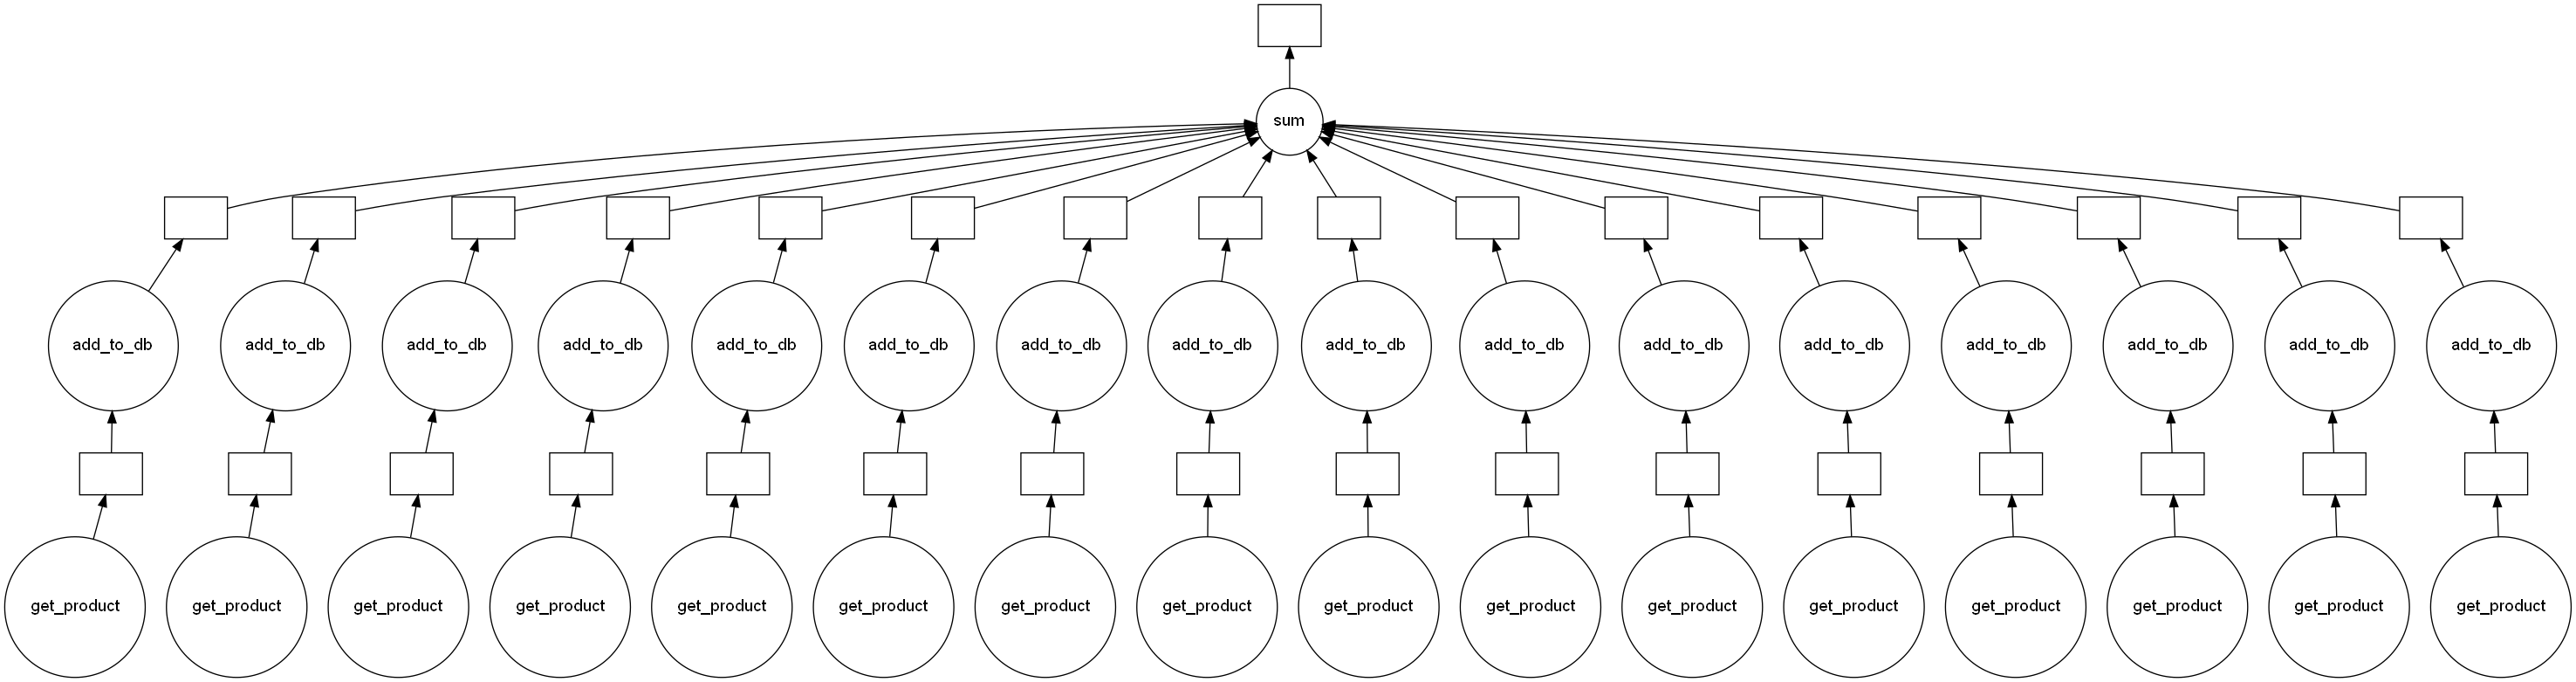

Здесь для каждого товара параллельно происходит вызов `get_product`, за которым следует вызов  `add_to_db`. Используя построенный граф, посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

В качестве демонстрации вставьте скриншот графа в процессе вычислений из дэшборда или результат работы метода `visualize`.

In [33]:
import os
graphviz_path = "C:/Users/vladi/Downloads/Graphviz/bin"
os.environ["PATH"] += (os.pathsep + graphviz_path)

Общая сумма добавленных товаров: 10656
Wall time: 17.9 s


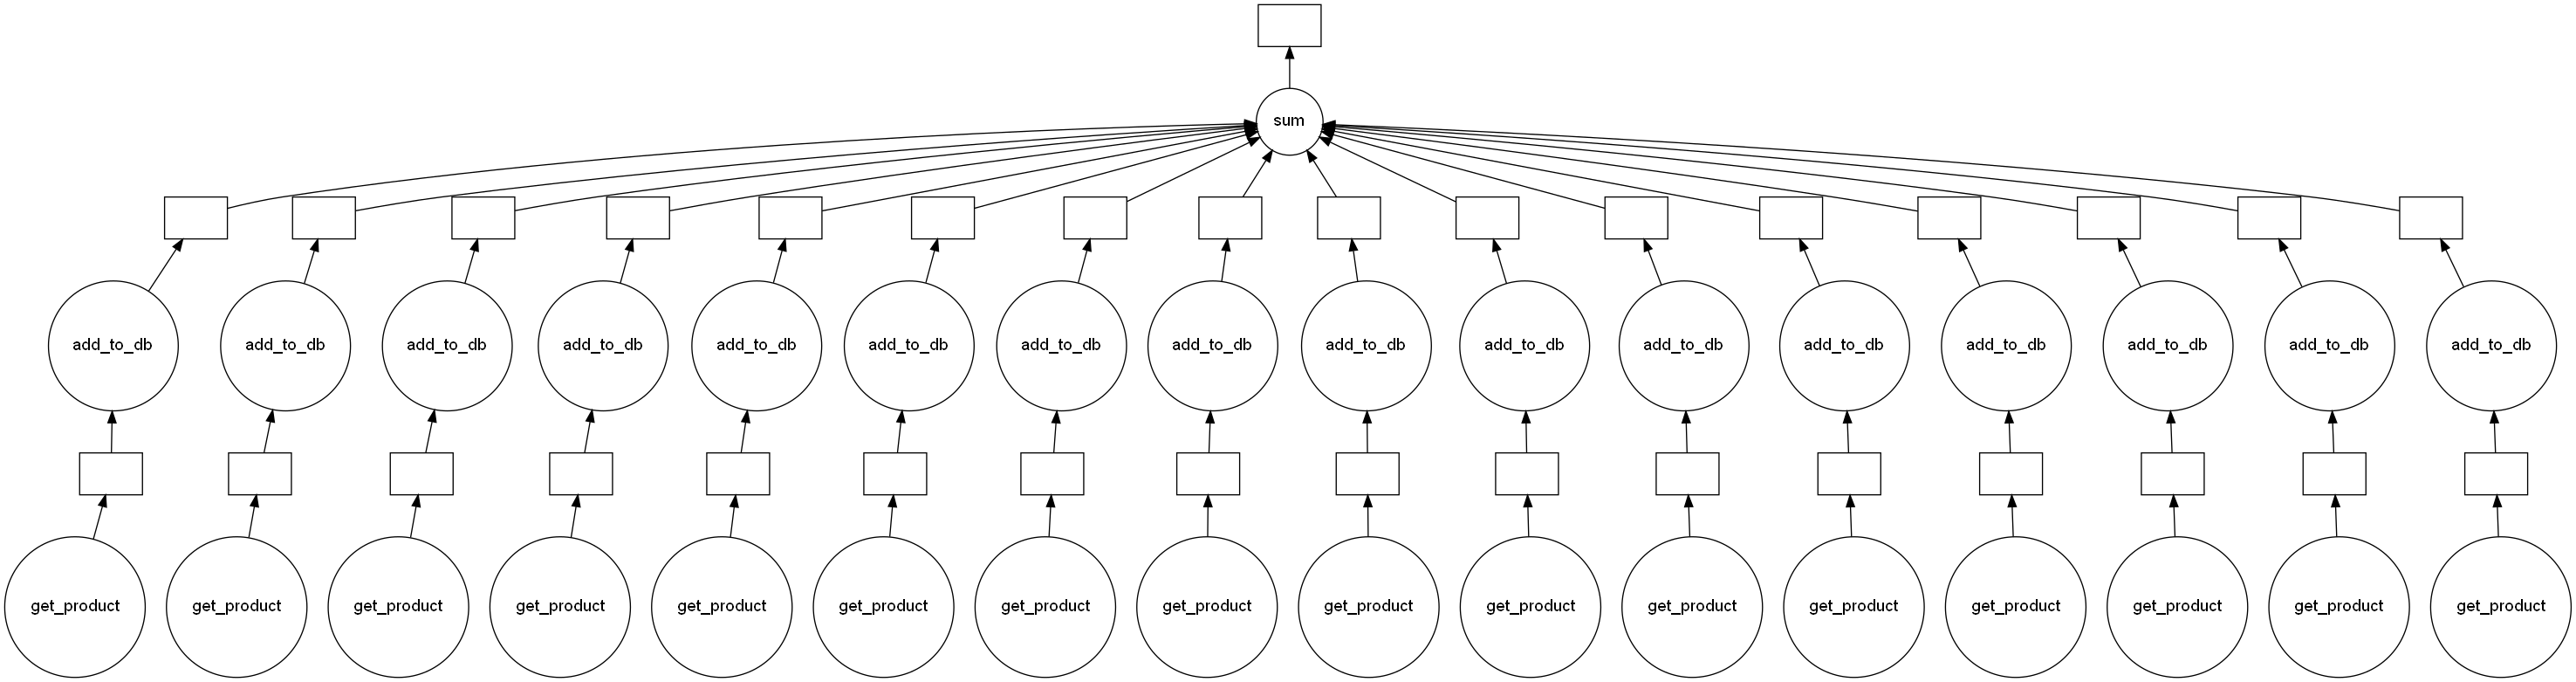

In [34]:
%%time

delayed_get_product = delayed(get_product)
delayed_add_to_db = delayed(add_to_db)

tasks = []
for pid in range(1, 17):
    product_task = delayed_get_product(pid)
    add_to_db_task = delayed_add_to_db(product_task)
    tasks.append(add_to_db_task)

total_sum = delayed(sum)(tasks)  # Обертка вызова sum() в delayed()

# Вывод общей суммы добавленных товаров
print("Общая сумма добавленных товаров:", total_sum.compute())

dask.visualize(total_sum)

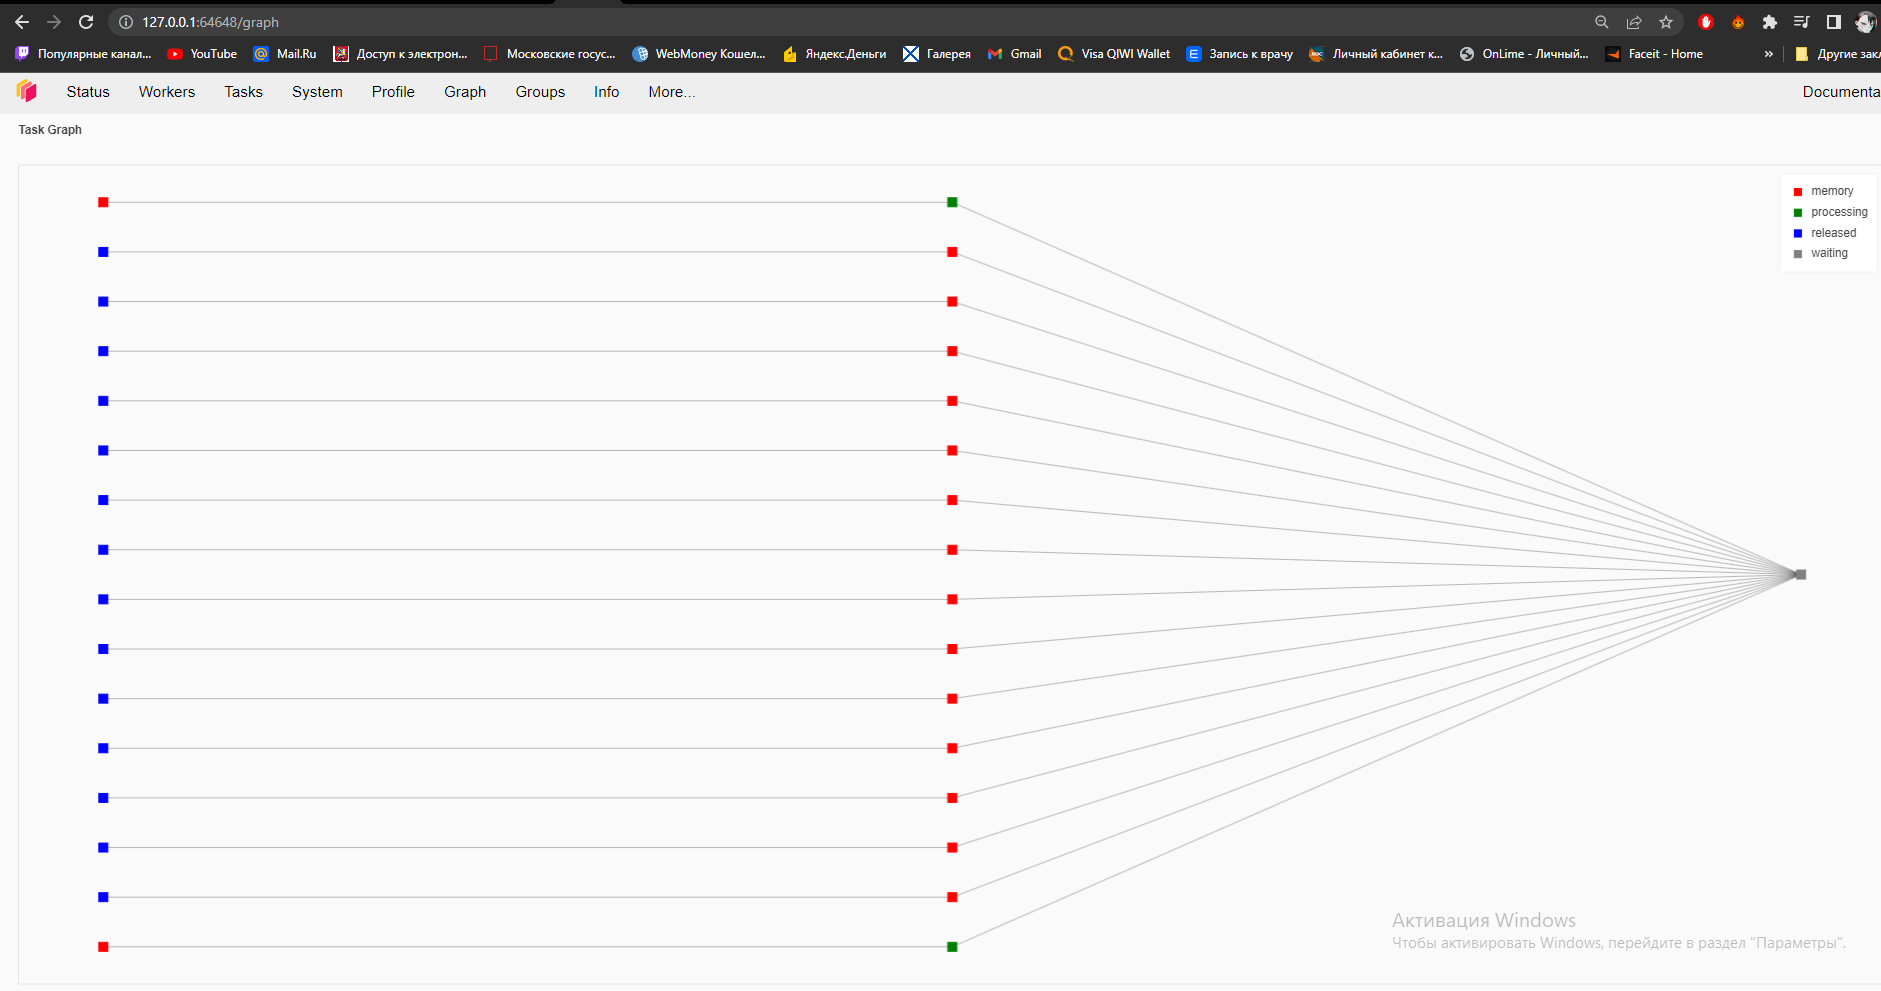

<p class="task" id="7"></p>

7\. Перестройте граф вычислений таким образом, чтобы на вход `add_to_db` передавалось сразу по 4 товара. Граф вычислений должен иметь следующий вид:

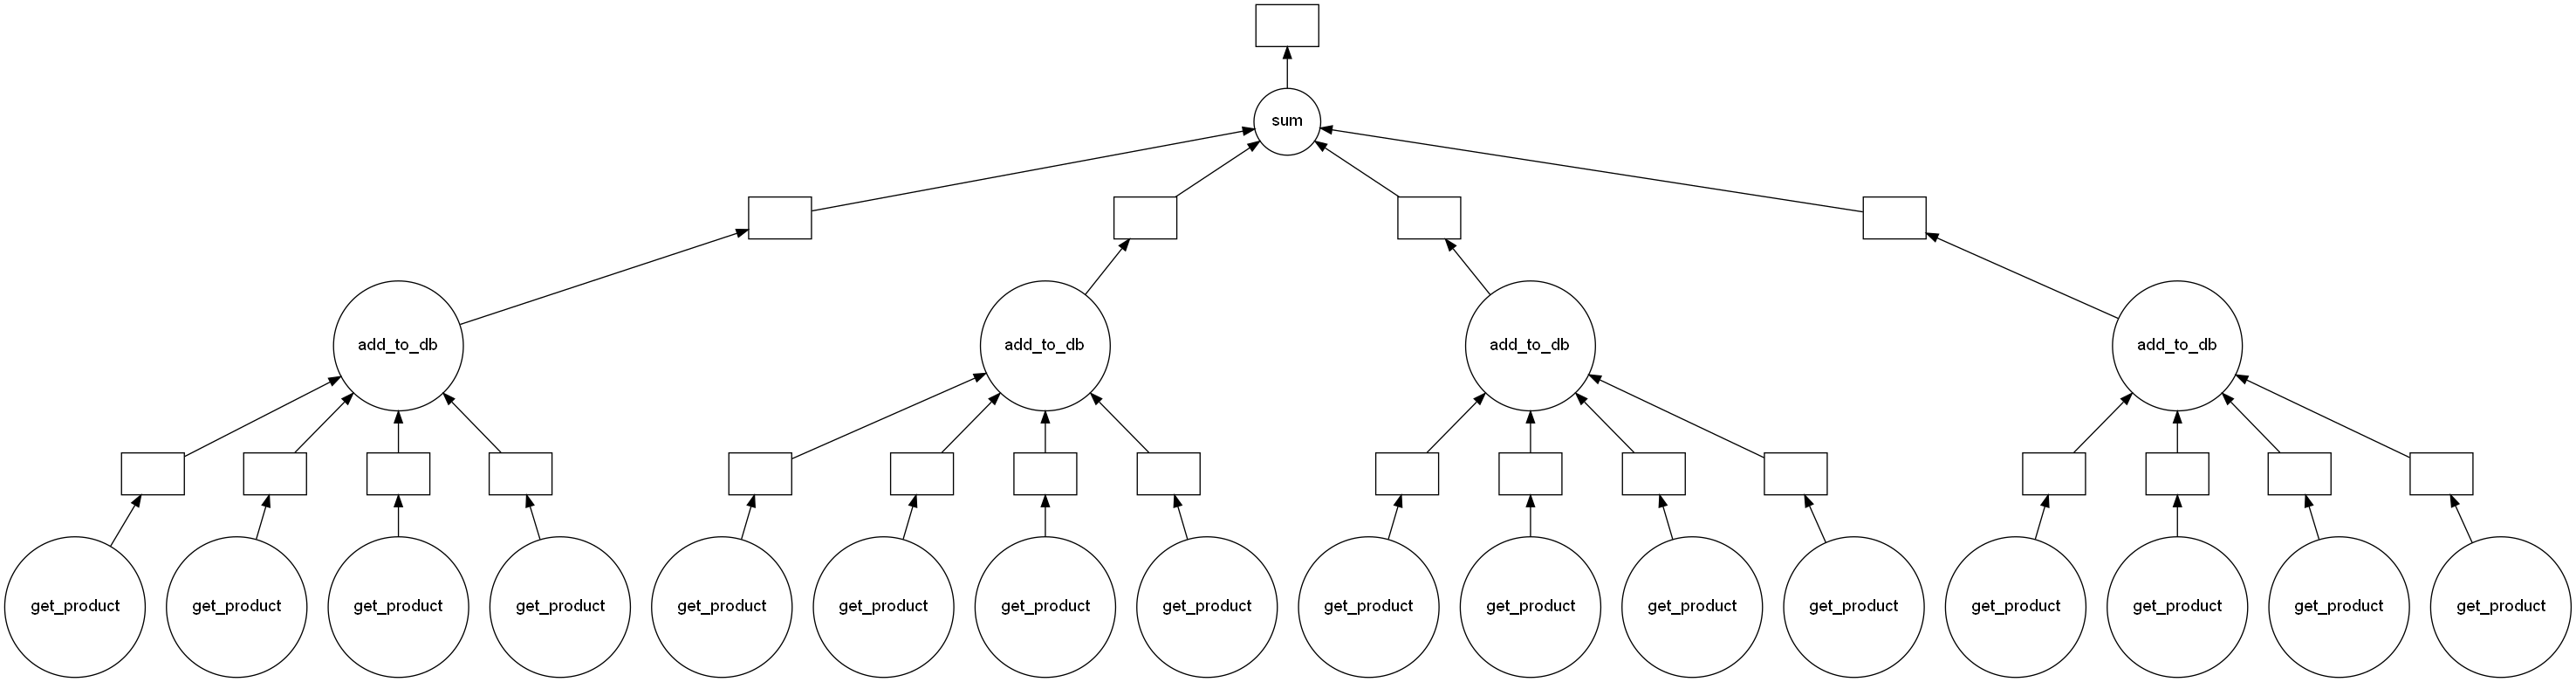

Используя построенный граф, посчитайте общую сумму добавленных товаров и выведите ее на экран. Замерьте время выполнения данного решения.

В качестве демонстрации вставьте скриншот графа в процессе вычислений из дэшборда или результат работы метода `visualize`.

Общая сумма добавленных товаров: 10656


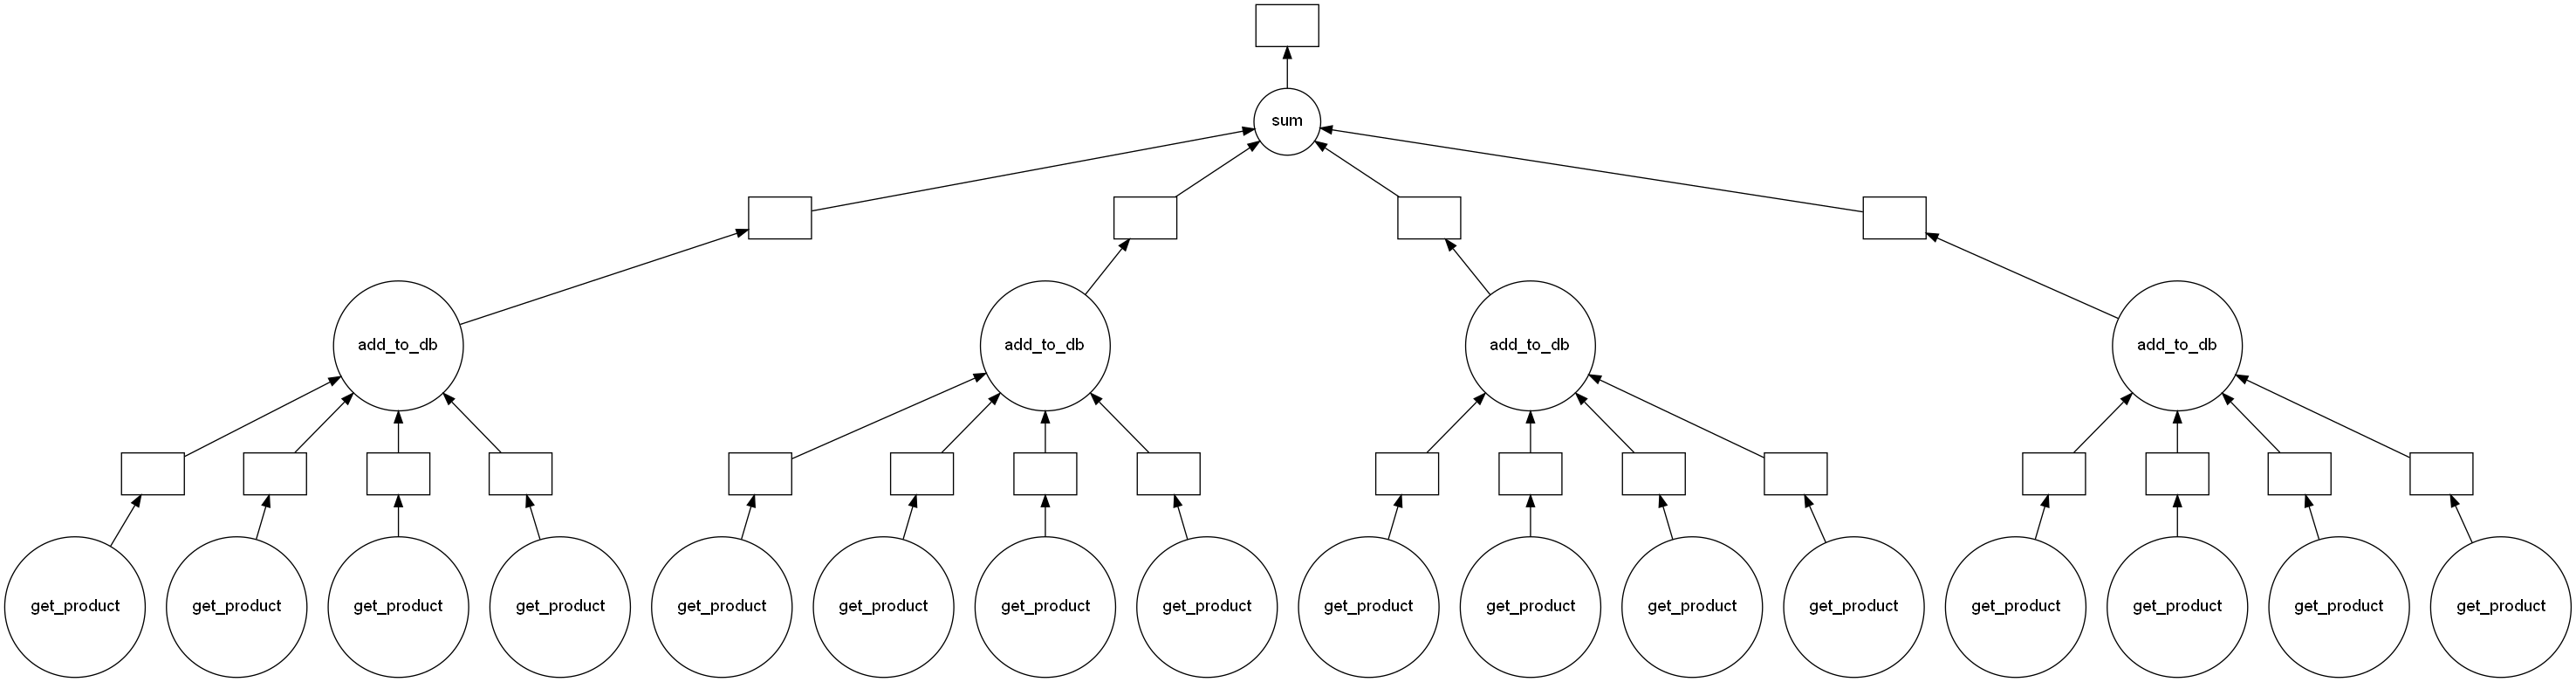

In [35]:
delayed_get_product = delayed(get_product)
delayed_add_to_db = delayed(add_to_db)

tasks = []
for start_pid in range(1, 17, 4):  # Шаг 4 для формирования списков из 4 товаров
    products = [delayed_get_product(pid) for pid in range(start_pid, start_pid + 4)]
    add_to_db_task = delayed_add_to_db(*products)  # Передача списка товаров в add_to_db
    tasks.append(add_to_db_task)

total_sum = delayed(sum)(tasks)  # Обертка вызова sum() в delayed()

# Вывод общей суммы добавленных товаров
print("Общая сумма добавленных товаров:", total_sum.compute())

dask.visualize(total_sum)

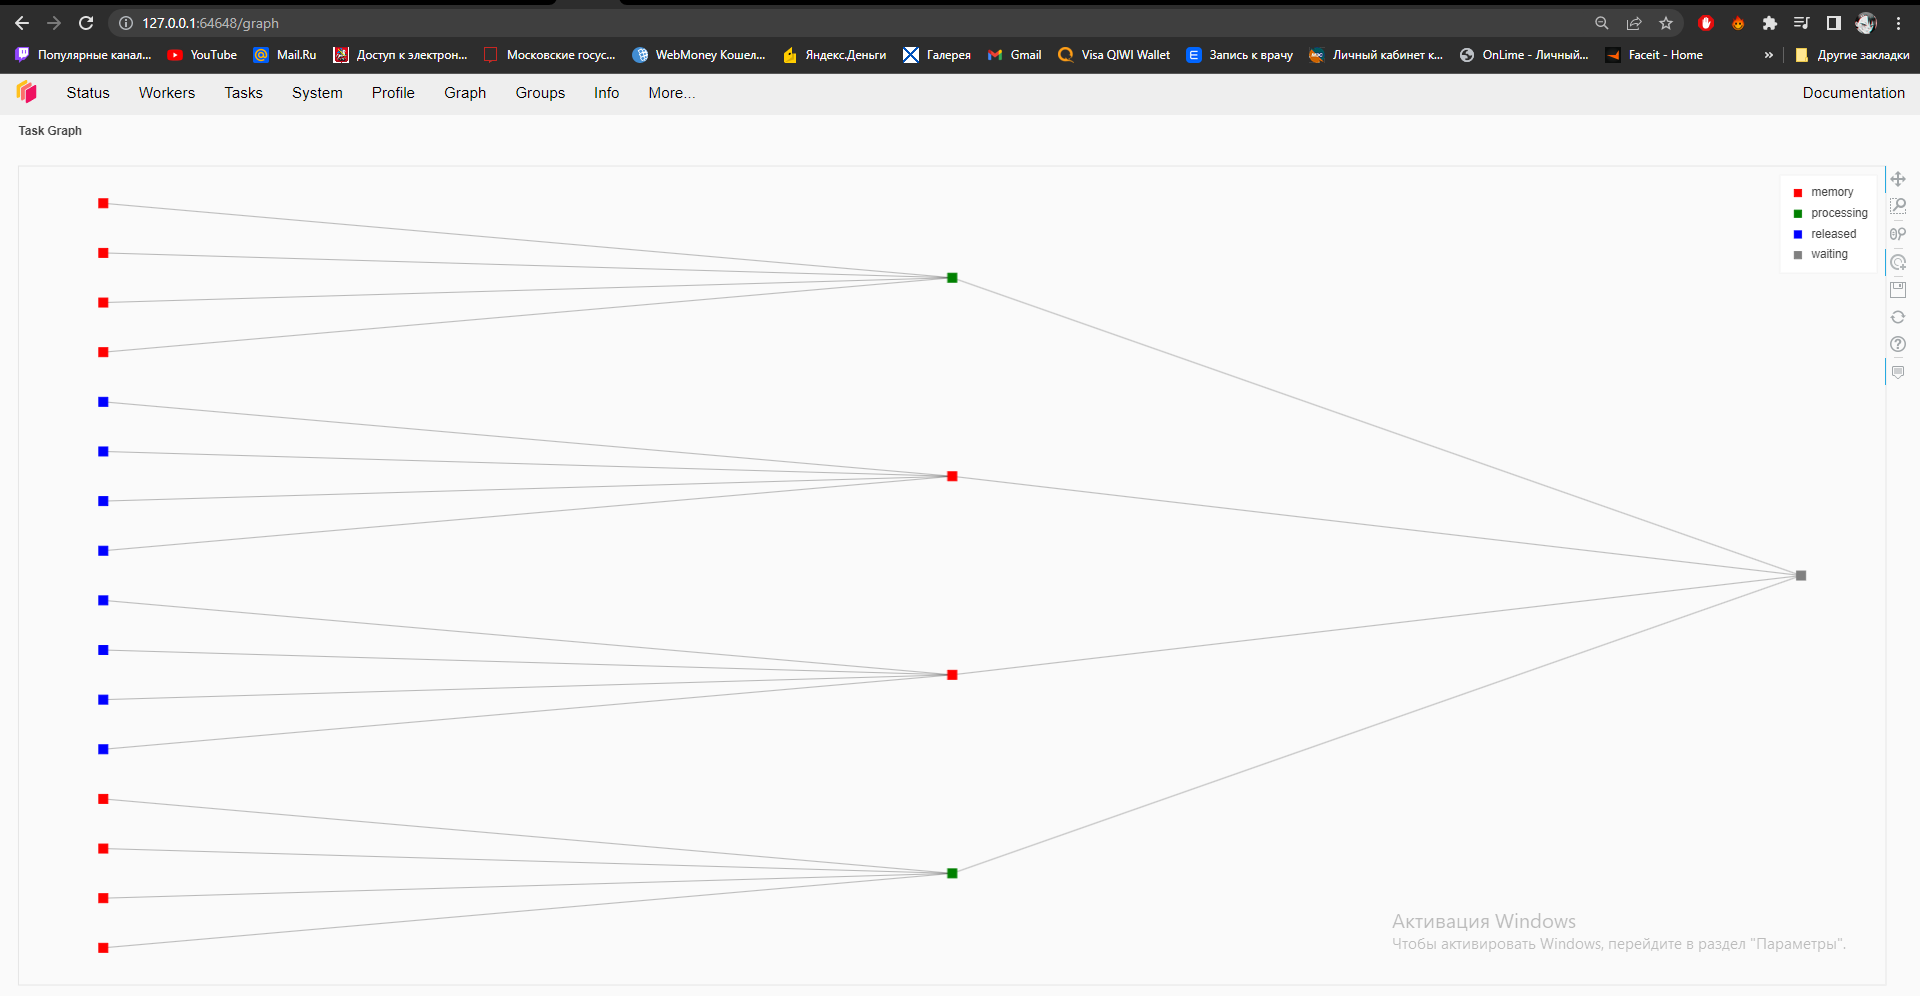